# Importing request

In [1]:
import requests
import json
from pprint import pprint
import pandas as pd
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import numpy as np
from config import api_key
from config import api_id
from config import api_key2

ModuleNotFoundError: No module named 'config'

# Creating random list for MSAs
Keith wrote the code to generate the random list from the top polluting MSAs

In [ ]:
# The data to load
f = "../data/msa.csv"

# Count the lines
num_lines = sum(1 for l in open(f))

# Sample size - retrieving header and 5 MSA's
size = 10

# The row indices to skip - make sure 0 is not included to keep the header
skip_idx = random.sample(range(1, num_lines), num_lines - size)

# Read the data
msa = pd.read_csv(f, skiprows=skip_idx)

# Display the sample
msa


# Striping Leading/Trailing Spaces for Merge

In [3]:
msa['MSA1']=msa['MSA'].str.strip()
msa

,MSA,MSA1
0,"Birmingham-Hoover-Talladega, AL","Birmingham-Hoover-Talladega, AL"
1,"Cincinnati-Wilmington-Maysville, OH-KY-IN","Cincinnati-Wilmington-Maysville, OH-KY-IN"
2,"Fresno-Madera-Hanford, CA","Fresno-Madera-Hanford, CA"
3,"Houston-The Woodlands, TX","Houston-The Woodlands, TX"
4,"McAllen-Edinburg, TX","McAllen-Edinburg, TX"
5,"Philadelphia-Reading-Camden, PA-NJ-DE-MD","Philadelphia-Reading-Camden, PA-NJ-DE-MD"
6,"Pittsburgh-New Castle-Weirton, PA-OH-WV","Pittsburgh-New Castle-Weirton, PA-OH-WV"
7,"Sacramento-Roseville, CA","Sacramento-Roseville, CA"
8,"Shreveport-Bossier City-Minden, LA","Shreveport-Bossier City-Minden, LA"


In [4]:
str(len(msa))

'9'

# Reading in MSA Crosswalk info for MSA codes

In [5]:
file = "../data/msa_crosswalk.csv"
crosswalk = pd.read_csv(file)
crosswalk1 = crosswalk[['CBSA Code','CSA Title']].sort_values('CSA Title',ascending = False).rename(columns = {'CSA Title':'MSA1'}).dropna().drop_duplicates()
crosswalk1.head()

,CBSA Code,MSA1
1503,41400,"Youngstown-Warren, OH-PA"
1893,49660,"Youngstown-Warren, OH-PA"
1865,48700,"Williamsport-Lock Haven, PA"
974,30820,"Williamsport-Lock Haven, PA"
1860,48620,"Wichita-Arkansas City-Winfield, KS"


# Joining MSA Crosswalk to Top MSAs to get the CBSA Codes needed for API Pulls

In [6]:
msa_codes = pd.merge(crosswalk1,msa,
                how = 'inner',
                on = 'MSA1')

print(msa_codes.head())
print('-----------------------------------------------------------------------')
print("There are multiple CBSA Codes per MSA, there were " + str(len(msa)) +" codes before join and  "+ str(len(msa_codes)) +" CBSA codes after the join.")

  CBSA Code                                     MSA1  \
0     40900                 Sacramento-Roseville, CA   
1     46020                 Sacramento-Roseville, CA   
2     49700                 Sacramento-Roseville, CA   
3     38300  Pittsburgh-New Castle-Weirton, PA-OH-WV   
4     48260  Pittsburgh-New Castle-Weirton, PA-OH-WV   

                                        MSA  
0                  Sacramento-Roseville, CA  
1                  Sacramento-Roseville, CA  
2                  Sacramento-Roseville, CA  
3   Pittsburgh-New Castle-Weirton, PA-OH-WV  
4   Pittsburgh-New Castle-Weirton, PA-OH-WV  
-----------------------------------------------------------------------
There are multiple CBSA Codes per MSA, there were 9 codes before join and  27 CBSA codes after the join.


# API Call - Pollution Part 1
using a for loop to loop through three years work of PM2.5 data

In [7]:
response_sample = []
start = ["20140101","20130101","20120101"]
end = ["20141231","20131231","20121231"]
codes = msa_codes['CBSA Code']


for index in range(len(start)):
    for each_msa in codes:
        url = f"https://aqs.epa.gov/data/api/sampleData/byCBSA?email={api_id}&key={api_key}&param=88101&bdate={start[index]}&edate={end[index]}&cbsa={each_msa}"
        response_sample.append(requests.get(url).json())

# Pulling Data and putting in list
There are two loops, the first loop is through the 33 different MSAs. Unfortunately the EPA does not always sample every 3 dyas like their website says. This leads to certain sampling sites having different lengths of samples. The second loop goes from 0 to the length of the number of samples they do have

In [8]:
time = []
date = []
cbsa_code = []
site = []
sample = []


for x in range(len(response_sample)):
# for x in range(0,32):
    for y in range(0,response_sample[x]['Header'][0]['rows']):
        time.append(response_sample[x]['Data'][y]['time_local'])
        date.append(response_sample[x]['Data'][y]['date_local'])
        cbsa_code.append(response_sample[x]['Data'][y]['cbsa_code'])
        site.append(response_sample[x]['Data'][y]['site_number'])
        sample.append(response_sample[x]['Data'][y]['sample_measurement'])

columns = ['time','date','cbsa_code','site','sample']
df_sample = pd.DataFrame(data = list(zip(time,date,cbsa_code,site,sample)), columns = columns)

df_sample.head()

,time,date,cbsa_code,site,sample
0,00:00,2014-01-01,40900,0003,-2.0
1,01:00,2014-01-01,40900,0003,0.0
2,02:00,2014-01-01,40900,0003,3.0
3,03:00,2014-01-01,40900,0003,1.0
4,04:00,2014-01-01,40900,0003,-2.0


# Converting date to DateTime
needed to group by month which is format that Oil Data is in

In [9]:
df_sample['date'] = pd.to_datetime(df_sample.date,format = '%Y-%m')
print(df_sample.head(1))
print('---------------------------------------------------------')
print("There are "+ str(len(df_sample)) +" rows of PM2.5 data")

    time       date cbsa_code  site  sample
0  00:00 2014-01-01     40900  0003    -2.0
---------------------------------------------------------
There are 635232 rows of PM2.5 data


In [10]:
df_sample['month_year'] = df_sample['date'].dt.strftime('%m-%Y')
df_sample.head(1)

,time,date,cbsa_code,site,sample,month_year
0,00:00,2014-01-01,40900,0003,-2.0,01-2014


converting sample to float to be used for regression/analysis later

In [11]:
df_sample= df_sample.astype({'sample': float})

# Grouping Hourly Data by day & Merging
PM2.5 data is organized by hour, but we need it on a daily level so it can map in with the AQI levels. First we do a groupby to get daily levels, then we need to remerge with the original data to get the categorical data back in (county, site, lat, lon)

In [12]:
df_sample1 = df_sample[['site','sample','month_year','cbsa_code']].groupby(['month_year','cbsa_code','site']).mean().reset_index().sort_values('month_year',ascending = False)
df_sample1.head()
len(df_sample1)
print(df_sample1.head(3))
print('-----------------------------------------')
print('There are '+ str(len(df_sample1)) + ' rows after grouping')

     month_year cbsa_code  site     sample
2508    12-2014     49700  0003   7.270000
2472    12-2014     37980  0057  15.609277
2456    12-2014     20100  0002   9.121192
-----------------------------------------
There are 2509 rows after grouping


# Creating Dummy Variables for Time and Sites

In [13]:
sample1 = pd.get_dummies(df_sample1[['month_year','site']])
sample1.head()

,month_year_01-2012,month_year_01-2013,month_year_01-2014,month_year_02-2012,month_year_02-2013,month_year_02-2014,month_year_03-2012,month_year_03-2013,month_year_03-2014,month_year_04-2012,...,site_1301,site_2003,site_2004,site_2059,site_3002,site_3007,site_4001,site_5001,site_5200,site_6004
2508,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2472,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2456,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2457,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2458,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Merging Dummy Variables Back In

In [14]:
sample2 = pd.concat([df_sample1,sample1],axis = 1).dropna()
sample2.head(2)

,month_year,cbsa_code,site,sample,month_year_01-2012,month_year_01-2013,month_year_01-2014,month_year_02-2012,month_year_02-2013,month_year_02-2014,...,site_1301,site_2003,site_2004,site_2059,site_3002,site_3007,site_4001,site_5001,site_5200,site_6004
2508,12-2014,49700,0003,7.270000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2472,12-2014,37980,0057,15.609277,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# API Call Census Data
pulling on 5 polluted state/counties from random selection of the top 20 highest polluted counties in the US

pulling sectors for mining/quarring, utilities, construction, manufactoring, & wholesale trade

https://classcodes.com/naics-2-digit-sector-codes/

In [15]:
year_survey = ['2016','2015','2014']
year_actual = ['2014','2013','2012']
variables_interest = ['NAICS2012_TTL,EMP,ESTAB']
sectors = ["31-33","21","22","42","48-49"]
# sectors =["31-33"]
codes = msa_codes['CBSA Code']
response_census = []
year_date = []


for index in range(len(year_survey)):
    for each_msa in codes:
        try:
            base_url = f"https://api.census.gov/data/{year_survey[index]}/cbp?get={variables_interest[0]}&NAICS2012={sectors[0]}&NAICS2012={sectors[1]}&NAICS2012={sectors[2]}&NAICS2012={sectors[3]}&NAICS2012={sectors[4]}&for=metropolitan%20statistical%20area/micropolitan%20statistical%20area:{each_msa}&key={api_key2}"
            response_census.append(requests.get(base_url).json())
            year_date.append(year_actual[index])
        except:
            print(f'MSA {each_msa} not found')

MSA 10760 not found
MSA 10760 not found
MSA 10760 not found


In [82]:
len(response_census[x])

5

In [84]:
naics2012_ttl = []
cbsa_code = []
emp = []
estab = []
sector = []
date = []

for x in range(len(response_census)):
    for y in range(len(response_census[x])):
        sector.append(response_census[x][y][0])
        cbsa_code.append(response_census[x][y][4])
        emp.append(response_census[x][y][1])
        estab.append(response_census[x][y][2]) 

In [85]:
sector

['NAICS2012_TTL',
 'Mining, quarrying, and oil and gas extraction',
 'Utilities',
 'Manufacturing',
 'Wholesale trade',
 'Transportation and warehousing',
 'NAICS2012_TTL',
 'Mining, quarrying, and oil and gas extraction',
 'Utilities',
 'Manufacturing',
 'Wholesale trade',
 'Transportation and warehousing',
 'NAICS2012_TTL',
 'Mining, quarrying, and oil and gas extraction',
 'Utilities',
 'Manufacturing',
 'Wholesale trade',
 'Transportation and warehousing',
 'NAICS2012_TTL',
 'Mining, quarrying, and oil and gas extraction',
 'Utilities',
 'Manufacturing',
 'Wholesale trade',
 'Transportation and warehousing',
 'NAICS2012_TTL',
 'Mining, quarrying, and oil and gas extraction',
 'Utilities',
 'Manufacturing',
 'Wholesale trade',
 'Transportation and warehousing',
 'NAICS2012_TTL',
 'Mining, quarrying, and oil and gas extraction',
 'Utilities',
 'Manufacturing',
 'Wholesale trade',
 'Transportation and warehousing',
 'NAICS2012_TTL',
 'Mining, quarrying, and oil and gas extraction',
 '

# Creating Census Dataset from Pulled Data
dropping first index as it is the column heading

In [86]:
columns = ['sector','cbsa_code','emp','estab','year']
census = pd.DataFrame(data = list(zip(sector,cbsa_code,emp,estab,year_date)), columns = columns)
print(census.head(5))
print('-----------------------------------------')
print('There are '+ str(len(census)) + ' rows')

                                          sector  \
0                                  NAICS2012_TTL   
1  Mining, quarrying, and oil and gas extraction   
2                                      Utilities   
3                                  Manufacturing   
4                                Wholesale trade   

                                           cbsa_code    emp  estab  year  
0  metropolitan statistical area/micropolitan sta...    EMP  ESTAB  2014  
1                                              40900    236     30  2014  
2                                              40900   3410     52  2014  
3                                              40900  33879   1368  2014  
4                                              40900  35499   2034  2014  
-----------------------------------------
There are 78 rows


# Creating Dummy Variables for Categorical Data of Industries and CBSA Codes

In [87]:
df2 = pd.get_dummies(census[['sector','year','cbsa_code']])
df2.head()

,sector_Manufacturing,"sector_Mining, quarrying, and oil and gas extraction",sector_NAICS2012_TTL,sector_Transportation and warehousing,sector_Utilities,sector_Wholesale trade,year_2012,year_2013,year_2014,cbsa_code_12100,...,cbsa_code_36140,cbsa_code_37980,cbsa_code_38300,cbsa_code_39740,cbsa_code_40900,cbsa_code_46020,cbsa_code_47220,cbsa_code_48260,cbsa_code_49700,cbsa_code_metropolitan statistical area/micropolitan statistical area
0,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
3,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


# Concatenating Dummy Variables back in

In [88]:
census_final = pd.concat([df2,census],axis = 1).dropna()
census_final.head()

,sector_Manufacturing,"sector_Mining, quarrying, and oil and gas extraction",sector_NAICS2012_TTL,sector_Transportation and warehousing,sector_Utilities,sector_Wholesale trade,year_2012,year_2013,year_2014,cbsa_code_12100,...,cbsa_code_46020,cbsa_code_47220,cbsa_code_48260,cbsa_code_49700,cbsa_code_metropolitan statistical area/micropolitan statistical area,sector,cbsa_code,emp,estab,year
0,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,NAICS2012_TTL,metropolitan statistical area/micropolitan sta...,EMP,ESTAB,2014
1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,"Mining, quarrying, and oil and gas extraction",40900,236,30,2014
2,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,Utilities,40900,3410,52,2014
3,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,Manufacturing,40900,33879,1368,2014
4,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,Wholesale trade,40900,35499,2034,2014


In [92]:
census_final = census_final[~census_final.emp.str.contains("EMP")]
census_final.head()

,sector_Manufacturing,"sector_Mining, quarrying, and oil and gas extraction",sector_NAICS2012_TTL,sector_Transportation and warehousing,sector_Utilities,sector_Wholesale trade,year_2012,year_2013,year_2014,cbsa_code_12100,...,cbsa_code_46020,cbsa_code_47220,cbsa_code_48260,cbsa_code_49700,cbsa_code_metropolitan statistical area/micropolitan statistical area,sector,cbsa_code,emp,estab,year
1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,"Mining, quarrying, and oil and gas extraction",40900,236,30,2014
2,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,Utilities,40900,3410,52,2014
3,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,Manufacturing,40900,33879,1368,2014
4,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,Wholesale trade,40900,35499,2034,2014
5,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,Transportation and warehousing,40900,26563,1177,2014


In [93]:
census_final= census_final.astype({'emp': float,
                                  'estab':float})
census_final.head()

,sector_Manufacturing,"sector_Mining, quarrying, and oil and gas extraction",sector_NAICS2012_TTL,sector_Transportation and warehousing,sector_Utilities,sector_Wholesale trade,year_2012,year_2013,year_2014,cbsa_code_12100,...,cbsa_code_46020,cbsa_code_47220,cbsa_code_48260,cbsa_code_49700,cbsa_code_metropolitan statistical area/micropolitan statistical area,sector,cbsa_code,emp,estab,year
1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,"Mining, quarrying, and oil and gas extraction",40900,236.0,30.0,2014
2,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,Utilities,40900,3410.0,52.0,2014
3,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,Manufacturing,40900,33879.0,1368.0,2014
4,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,Wholesale trade,40900,35499.0,2034.0,2014
5,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,Transportation and warehousing,40900,26563.0,1177.0,2014


# Reading in and Cleaning Oil Data

In [94]:
#remove rows before 198
file = "../data/Crude_oil_prices.csv"
oil = pd.read_csv(file)
oil_data=oil[(oil['Year']>1984)]
oil_data['date'] = pd.to_datetime(oil_data[['Year', 'Month']].assign(DAY=1))
oil_data= oil_data.drop(columns=['Free on Board Cost of Crude Oil Imports (Dollars per Barrel)',
                                 'Landed Cost of Crude Oil Imports (Dollars per Barrel)',
                                 'Refiner Acquisition Cost of Crude Oil, Domestic (Dollars per Barrel)',
                                 'Refiner Acquisition Cost of Crude Oil, Imported (Dollars per Barrel)',
                                 'Refiner Acquisition Cost of Crude Oil, Composite (Dollars per Barrel)','Month','Year'])
oil_data.head()

C:\Users\adfil\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Crude Oil Domestic First Purchase Price (Dollars per Barrel),date
159,24.26,1985-01-01
160,23.64,1985-02-01
161,23.89,1985-03-01
162,24.19,1985-04-01
163,24.18,1985-05-01


In [95]:
oil_data= oil_data.rename(columns={"Crude Oil Domestic First Purchase Price (Dollars per Barrel)":'Crude_Oil_Price'})
oil_data= oil_data[['date','Crude_Oil_Price']]
index= oil_data[(oil_data['Crude_Oil_Price'] =='Not Available')].index

oil_data.drop(index, inplace=True)

oil_data.head()

,date,Crude_Oil_Price
159,1985-01-01,24.26
160,1985-02-01,23.64
161,1985-03-01,23.89
162,1985-04-01,24.19
163,1985-05-01,24.18


In [96]:
oil_data['month_year'] = oil_data['date'].dt.strftime('%m-%Y')
oil_data.head()

,date,Crude_Oil_Price,month_year
159,1985-01-01,24.26,01-1985
160,1985-02-01,23.64,02-1985
161,1985-03-01,23.89,03-1985
162,1985-04-01,24.19,04-1985
163,1985-05-01,24.18,05-1985


In [97]:
oil_data= oil_data.astype({'Crude_Oil_Price': float})
oil_data.head()

,date,Crude_Oil_Price,month_year
159,1985-01-01,24.26,01-1985
160,1985-02-01,23.64,02-1985
161,1985-03-01,23.89,03-1985
162,1985-04-01,24.19,04-1985
163,1985-05-01,24.18,05-1985


In [98]:
oil_data1 = oil_data.groupby('month_year').mean().reset_index()
oil_data1.head()

,month_year,Crude_Oil_Price
0,01-1985,24.26
1,01-1986,23.12
2,01-1987,13.79
3,01-1988,13.64
4,01-1989,13.80


# Merging in Oil Prices into Census & Pollution Data

In [99]:
pm25_census = pd.merge(sample2, census_final,
                      how = 'inner',
                      on = 'cbsa_code')
pm25_census.head()

,month_year,cbsa_code,site,sample,month_year_01-2012,month_year_01-2013,month_year_01-2014,month_year_02-2012,month_year_02-2013,month_year_02-2014,...,cbsa_code_40900,cbsa_code_46020,cbsa_code_47220,cbsa_code_48260,cbsa_code_49700,cbsa_code_metropolitan statistical area/micropolitan statistical area,sector,emp,estab,year
0,12-2014,49700,0003,7.27,0,0,0,0,0,0,...,0,0,0,0,1,0,"Mining, quarrying, and oil and gas extraction",138.0,10.0,2014
1,12-2014,49700,0003,7.27,0,0,0,0,0,0,...,0,0,0,0,1,0,Utilities,279.0,11.0,2014
2,12-2014,49700,0003,7.27,0,0,0,0,0,0,...,0,0,0,0,1,0,Manufacturing,1966.0,90.0,2014
3,12-2014,49700,0003,7.27,0,0,0,0,0,0,...,0,0,0,0,1,0,Wholesale trade,2086.0,108.0,2014
4,12-2014,49700,0003,7.27,0,0,0,0,0,0,...,0,0,0,0,1,0,Transportation and warehousing,1009.0,126.0,2014


In [100]:
pm25_census_oil = pd.merge(pm25_census, oil_data1,
                          how = 'inner',
                          on = 'month_year')
pm25_census_oil.head()
list(pm25_census_oil.columns)

['month_year',
 'cbsa_code',
 'site',
 'sample',
 'month_year_01-2012',
 'month_year_01-2013',
 'month_year_01-2014',
 'month_year_02-2012',
 'month_year_02-2013',
 'month_year_02-2014',
 'month_year_03-2012',
 'month_year_03-2013',
 'month_year_03-2014',
 'month_year_04-2012',
 'month_year_04-2013',
 'month_year_04-2014',
 'month_year_05-2012',
 'month_year_05-2013',
 'month_year_05-2014',
 'month_year_06-2012',
 'month_year_06-2013',
 'month_year_06-2014',
 'month_year_07-2012',
 'month_year_07-2013',
 'month_year_07-2014',
 'month_year_08-2012',
 'month_year_08-2013',
 'month_year_08-2014',
 'month_year_09-2012',
 'month_year_09-2013',
 'month_year_09-2014',
 'month_year_10-2012',
 'month_year_10-2013',
 'month_year_10-2014',
 'month_year_11-2012',
 'month_year_11-2013',
 'month_year_11-2014',
 'month_year_12-2012',
 'month_year_12-2013',
 'month_year_12-2014',
 'site_0001',
 'site_0002',
 'site_0003',
 'site_0004',
 'site_0005',
 'site_0006',
 'site_0008',
 'site_0010',
 'site_0011

In [110]:
y = pm25_census_oil['sample']
 = pm25_census_oil[['Crude_Oil_Price','sector_Manufacturing','sector_Mining, quarrying, and oil and gas extraction','sector_Transportation and warehousing','sector_Utilities','emp','estab','year_2012','year_2013']]

# Creating Test and Training Data for Linear Regression and ML

## Creating X and Y variables 
dropping year December 2014, cbsa 49700, site 1007,and sector Utilities for dummies

In [122]:
X = pm25_census_oil.drop(columns = [
    'month_year','cbsa_code','site','sample','sector','year',
    'cbsa_code_49700','year_2014','year_2012','year_2013',
    'month_year_12-2014','sector_NAICS2012_TTL','sector_Utilities',
    'cbsa_code_metropolitan statistical area/micropolitan statistical area',
    'site_1007'])

y = pm25_census_oil['sample'].values.reshape(-1,1)

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

C:\Users\adfil\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  


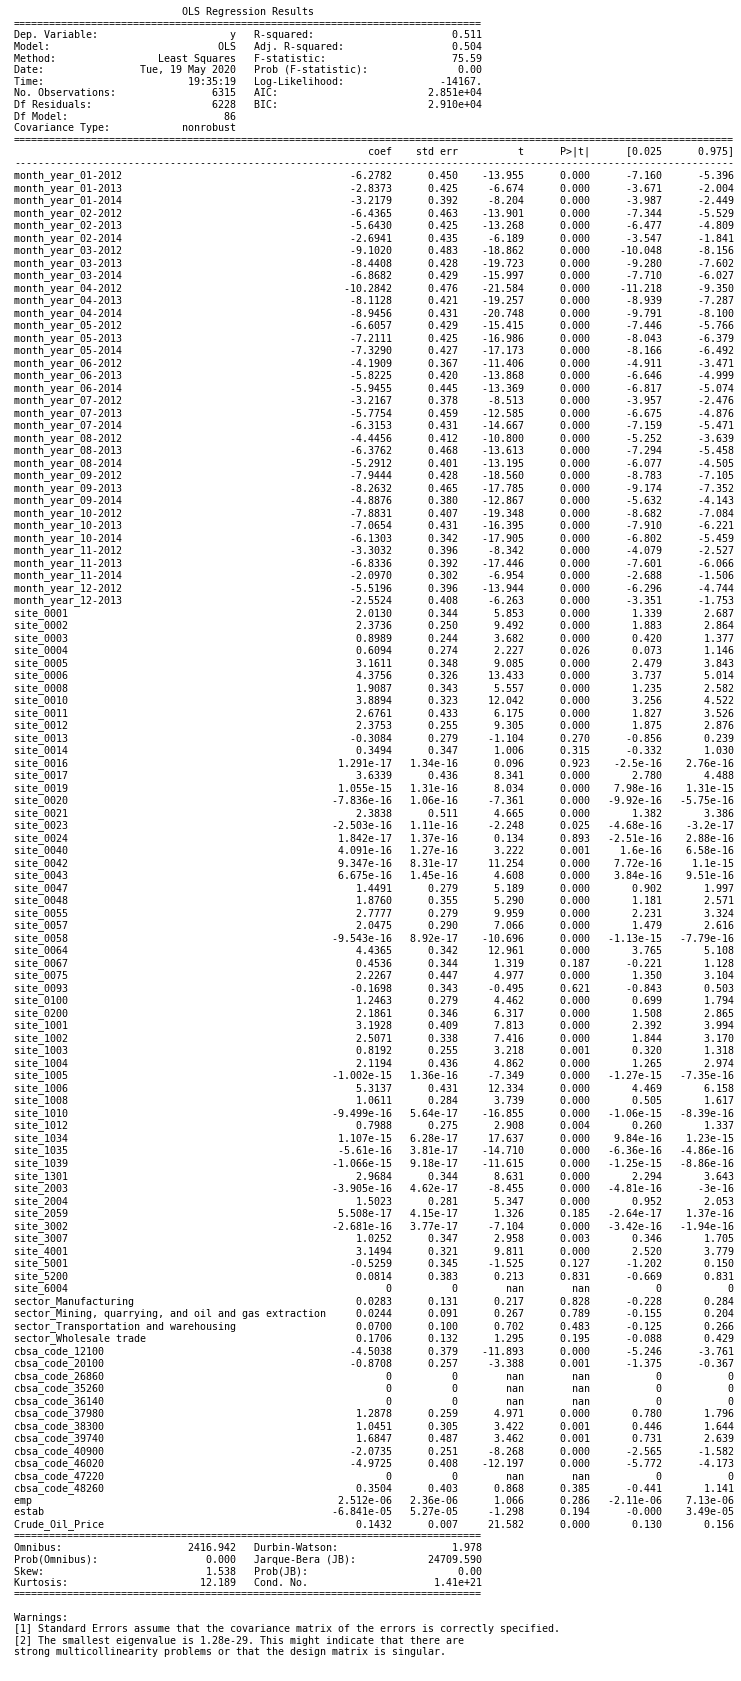

In [124]:
model = sm.OLS(y_train,X_train).fit()
predictions = model.predict(X_test)
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.show()

# Exporting PM2.5, Census, Oil Data to CSV to use in Tableau

In [45]:
export_file = pm25_census_oil[['Crude_Oil_Price','sector','sample','site','month_year','emp','estab','cbsa_code']]

export_file.to_csv('../data/pm25_census_oil.csv')


# Machine Learning
#### Preprocessing
dropping categorical variables, and one variable for reference variable 

#### Reshaping data

In [ ]:
X = pm25_census_oil.drop(columns = [
    'month_year','cbsa_code','site','sample','sector','year',
    'cbsa_code_49700','year_2014','year_2012','year_2013',
    'month_year_12-2014'])

y = pm25_census_oil['sample'].values.reshape(-1,1)
print(X.shape,y.shape)


#### Splitting and Training Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [125]:
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

In [126]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [127]:
model = LinearRegression()
model.fit(X_train_scaled, y_train_scaled)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

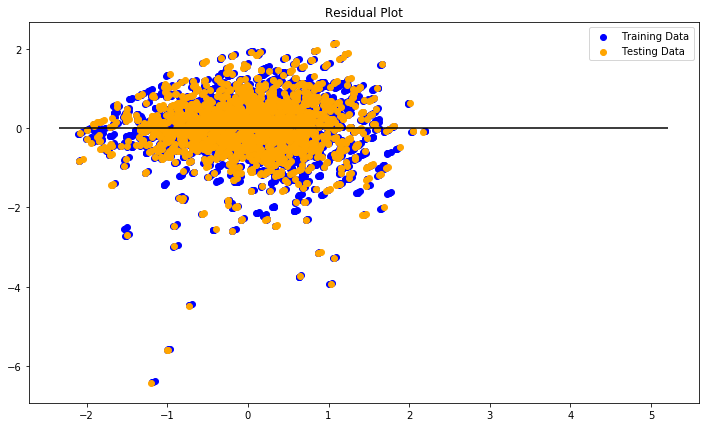

In [132]:
### BEGIN SOLUTION
predictions = model.predict(X_test_scaled)
model.fit(X_train_scaled, y_train_scaled)
plt.scatter(model.predict(X_train_scaled), model.predict(X_train_scaled) - y_train_scaled, c="blue", label="Training Data")
plt.scatter(model.predict(X_test_scaled), model.predict(X_test_scaled) - y_test_scaled, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test_scaled.min(), xmax=y_test_scaled.max())
plt.title("Residual Plot")
plt.show()
### END SOLUTION

In [133]:
### BEGIN SOLUTION
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = model.score(X_test_scaled, y_test_scaled)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.512268450131165, R2: 0.479406850360348


In [134]:
# LASSO model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Lasso

### BEGIN SOLUTION
lasso = Lasso(alpha=.01).fit(X_train_scaled, y_train_scaled)

predictions = lasso.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = lasso.score(X_test_scaled, y_test_scaled)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.5199010449734138, R2: 0.471650220827859


In [135]:
# Ridge model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Ridge

### BEGIN SOLUTION
ridge = Ridge(alpha=.01).fit(X_train_scaled, y_train_scaled)

predictions = ridge.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = ridge.score(X_test_scaled, y_test_scaled)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.5118355348534878, R2: 0.4798468007962481


In [136]:
# ElasticNet model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import ElasticNet

### BEGIN SOLUTION
elasticnet = ElasticNet(alpha=.01).fit(X_train_scaled, y_train_scaled)

predictions = elasticnet.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = elasticnet.score(X_test_scaled, y_test_scaled)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.513325393125306, R2: 0.4783327313468335
